In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly
import matplotlib as plt
import plotly.graph_objects as go
import plotly.express as px
from datetime import date, timedelta
import folium
from scipy.interpolate import interp1d
import plotly.io as pio
pio.orca.config.executable = 'orca.exe'
plotly.io.orca.config.save()
pio.renderers.default = "svg"

## Questions (Pre-analytics)



### 1. What is the distribution of COVID-19 Cases by state in the US (live, most recent data available)?
### 2. What is the distribution of COVID-19 Cases by Counties in each State (live, most recent data available)?
### 3. Can the latest COVID-19 Cases be shown on the US Map?
### 4. How does the proportion of total deaths to total cases measure up based on the latest data available?
### 5. What are the top five states in the US currently (real time) having the most number of COVID-19 Cases?
### 6. What is the trend of the cases in these top five states in the last thirty days (real time)?

##### Credits: New York Times Github link (see next cell) with live data on COVID-19 in the US

In [109]:
covid = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv", error_bad_lines = False)

In [110]:
covid.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [111]:
covid.shape

(414948, 6)

In [112]:
del covid["fips"]

In [113]:
covid.head()

,date,county,state,cases,deaths
0,2020-01-21,Snohomish,Washington,1,0
1,2020-01-22,Snohomish,Washington,1,0
2,2020-01-23,Snohomish,Washington,1,0
3,2020-01-24,Cook,Illinois,1,0
4,2020-01-24,Snohomish,Washington,1,0


In [114]:
covid_states = covid.state.value_counts().to_frame()
covid_states_lst = list(covid_states.index)
print(covid_states_lst)

['Texas', 'Georgia', 'Virginia', 'Kentucky', 'Missouri', 'North Carolina', 'Illinois', 'Tennessee', 'Iowa', 'Indiana', 'Ohio', 'Kansas', 'Mississippi', 'Minnesota', 'Michigan', 'Arkansas', 'Oklahoma', 'Florida', 'Wisconsin', 'Pennsylvania', 'Alabama', 'Nebraska', 'Louisiana', 'Colorado', 'New York', 'California', 'Puerto Rico', 'South Dakota', 'West Virginia', 'South Carolina', 'North Dakota', 'Washington', 'Idaho', 'Montana', 'Oregon', 'New Mexico', 'Utah', 'Maryland', 'New Jersey', 'Wyoming', 'Alaska', 'Maine', 'Massachusetts', 'Arizona', 'Vermont', 'Nevada', 'New Hampshire', 'Connecticut', 'Rhode Island', 'Hawaii', 'Delaware', 'Virgin Islands', 'Northern Mariana Islands', 'District of Columbia', 'Guam']


In [115]:
covid.columns

Index(['date', 'county', 'state', 'cases', 'deaths'], dtype='object')

## Calculating the latest date (3 days ago)

In [116]:
today = date.today()
three_days_back = (today - timedelta(days=3)).strftime('%Y-%m-%d')
covid_latest = covid[covid.date.eq(three_days_back)]
covid_latest.head()

,date,county,state,cases,deaths
405287,2020-08-06,Autauga,Alabama,1096,22
405288,2020-08-06,Baldwin,Alabama,3438,25
405289,2020-08-06,Barbour,Alabama,619,5
405290,2020-08-06,Bibb,Alabama,421,4
405291,2020-08-06,Blount,Alabama,874,3


## Summing the total number of cases & deaths by State based on the 'latest date'

In [117]:
scd = pd.DataFrame(columns = ["state", "total_cases", "total_deaths"])
scd

,state,total_cases,total_deaths


In [118]:
scd["state"] = pd.Series(covid_states_lst)
scd["total_cases"] = pd.Series(covid_states_lst)
scd["total_deaths"] = pd.Series(covid_states_lst)
scd = scd.sort_values(by = "state")
scd.head()

,state,total_cases,total_deaths
20,Alabama,Alabama,Alabama
40,Alaska,Alaska,Alaska
43,Arizona,Arizona,Arizona
15,Arkansas,Arkansas,Arkansas
25,California,California,California


In [119]:
for state in covid_states_lst:
    total_case_count = covid_latest.loc[covid["state"] == state, "cases"].sum()
    total_death_count = covid_latest.loc[covid["state"] == state, "deaths"].sum()
    scd["total_cases"] = scd["total_cases"].replace(state, total_case_count)
    scd["total_deaths"] = scd["total_deaths"].replace(state, total_death_count)

In [120]:
scd[scd.state.eq("California")]

,state,total_cases,total_deaths
25,California,541013,10014


In [121]:
covid_states_lst = sorted(list(covid_states.index))
print(covid_states_lst)
print(len(covid_states_lst))

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Northern Mariana Islands', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
55


## Visualizing the total number of COVID-19 Cases & Deaths in each State in the US

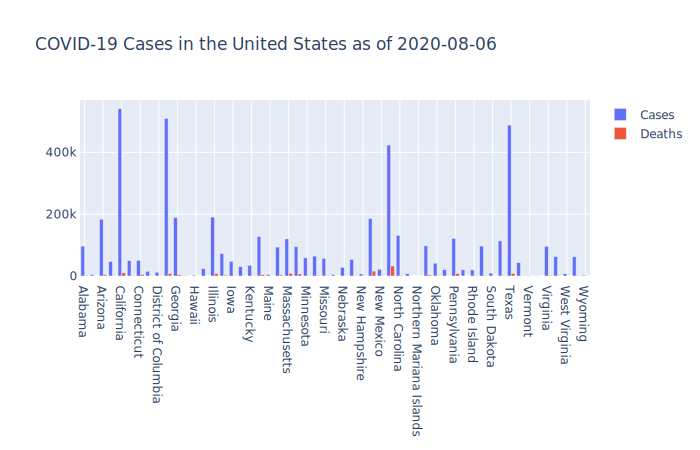

In [122]:
fig = go.Figure(data=[
    go.Bar(name='Cases', x=covid_states_lst, y=scd["total_cases"]),
    go.Bar(name='Deaths', x=covid_states_lst, y=scd["total_deaths"])
]
)
fig.update_layout(title="COVID-19 Cases in the United States as of " + three_days_back, barmode='group')
fig.show()

## Visualizing the number of COVID-19 Cases by State AND County based on the 'latest date'

In [123]:
fig = px.sunburst(covid_latest, path=['state','county'], values = 'cases')
fig.update_layout(title = "COVID-19 Cases by State, County as of " + three_days_back)
fig.show()

## Importing 'states.csv' which contains the latitude and longitude of each state in the US

In [124]:
STATES = pd.read_csv("states.csv")

In [125]:
STATES.head()

,state,latitude,longitude,name
0,AK,63.588753,-154.493062,Alaska
1,AL,32.318231,-86.902298,Alabama
2,AR,35.201050,-91.831833,Arkansas
3,AZ,34.048928,-111.093731,Arizona
4,CA,36.778261,-119.417932,California


In [126]:
STATES_LST = list(STATES["name"])
print(STATES_LST)

['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California', 'Colorado', 'Connecticut', 'District of Columbia', 'Delaware', 'Florida', 'Georgia', 'Guam', 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana', 'Kansas', 'Kentucky', 'Louisiana', 'Massachusetts', 'Maryland', 'Maine', 'Michigan', 'Minnesota', 'Missouri', 'Northern Mariana Islands', 'Mississippi', 'Montana', 'North Carolina', 'North Dakota', 'Nebraska', 'New Hampshire', 'New Jersey', 'New Mexico', 'Nevada', 'New York', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Virgin Islands', 'Vermont', 'Washington', 'Wisconsin', 'West Virginia', 'Wyoming']


In [127]:
STATES.columns = ["ISO", "Lat", "Lon", "state"]
STATES.head()

,ISO,Lat,Lon,state
0,AK,63.588753,-154.493062,Alaska
1,AL,32.318231,-86.902298,Alabama
2,AR,35.201050,-91.831833,Arkansas
3,AZ,34.048928,-111.093731,Arizona
4,CA,36.778261,-119.417932,California


In [128]:
covid_LL = covid_latest
covid_LL.head()

,date,county,state,cases,deaths
405287,2020-08-06,Autauga,Alabama,1096,22
405288,2020-08-06,Baldwin,Alabama,3438,25
405289,2020-08-06,Barbour,Alabama,619,5
405290,2020-08-06,Bibb,Alabama,421,4
405291,2020-08-06,Blount,Alabama,874,3


In [129]:
merged_covid = pd.merge(scd, STATES, on = "state")
merged_covid.head()

,state,total_cases,total_deaths,ISO,Lat,Lon
0,Alabama,96592,1714,AL,32.318231,-86.902298
1,Alaska,4221,23,AK,63.588753,-154.493062
2,Arizona,183744,4005,AZ,34.048928,-111.093731
3,Arkansas,47028,515,AR,35.201050,-91.831833
4,California,541013,10014,CA,36.778261,-119.417932


## Visualizing the number of COVID-19 Cases by State based on the 'latest date' in a heatmap

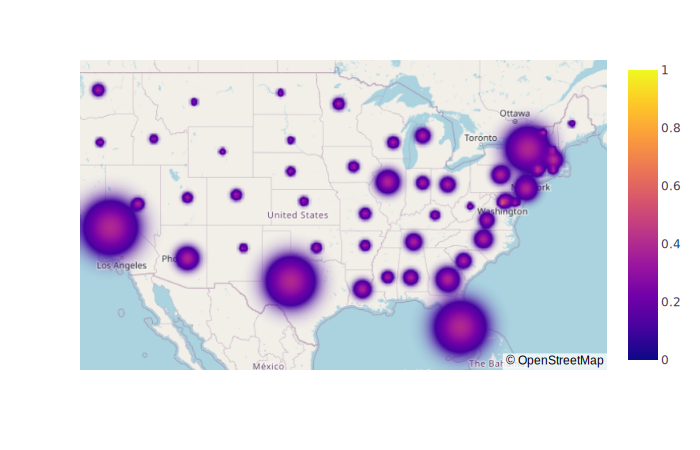

In [155]:
total_cases_lst = merged_covid.total_cases.values.tolist()
m = interp1d([1, max(total_cases_lst)], [5, 50])
circle_radius = m(total_cases_lst)
fig = px.density_mapbox(merged_covid, lat = "Lat", lon = "Lon", radius = circle_radius, zoom = 2.7, mapbox_style = "open-street-map")
fig.show()

# Total Number of Cases vs Total Number of Deaths (Most Updated)

In [131]:
cases_latest = covid_LL.cases.sum()
deaths_latest = covid_LL.deaths.sum()
total_cases = pd.DataFrame({"Total Cases": [cases_latest], "Total Deaths": [deaths_latest]})
total_cases.head()

,Total Cases,Total Deaths
0,4889740,159365


In [132]:
total_cases.iloc[0].to_list()

[4889740, 159365]

In [133]:
total_cases.columns.to_list()

['Total Cases', 'Total Deaths']

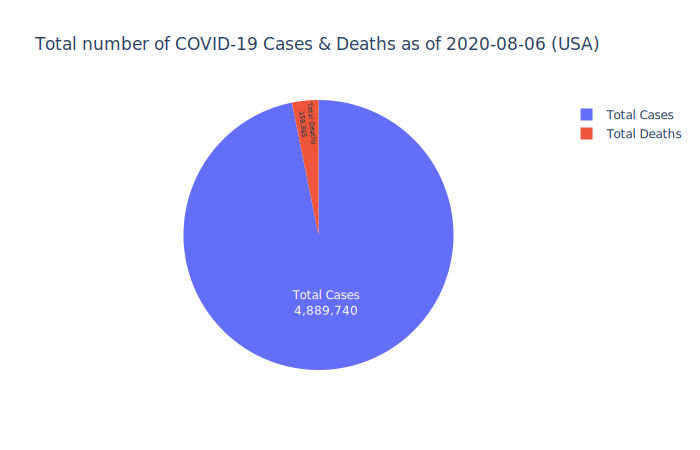

In [134]:
fig = px.pie(total_cases, values = total_cases.iloc[0].to_list(), names = total_cases.columns.to_list(), title = "Total number of COVID-19 Cases & Deaths as of " + three_days_back + " (USA)")
fig.update_traces(textposition = "inside", textinfo = 'label+value')
fig.show()

## Calculating the date 30 days ago from today

In [135]:
thirty_days_back = (today - timedelta(days=30)).strftime('%Y-%m-%d')
covid_thirty_latest = covid[covid.date >= (thirty_days_back)]
tdb = covid_thirty_latest
tdb.head()

,date,county,state,cases,deaths
318745,2020-07-10,Autauga,Alabama,670,15
318746,2020-07-10,Baldwin,Alabama,1187,12
318747,2020-07-10,Barbour,Alabama,381,2
318748,2020-07-10,Bibb,Alabama,218,1
318749,2020-07-10,Blount,Alabama,292,1


## Discovering the 5 states with the highest number of COVID-19 Cases based on the 'latest date'

In [136]:
top_five_latest = merged_covid.sort_values(by = "total_cases", ascending = False).head()
top_five_latest

,state,total_cases,total_deaths,ISO,Lat,Lon
4,California,541013,10014,CA,36.778261,-119.417932
9,Florida,510381,7746,FL,27.664827,-81.515754
46,Texas,488240,8397,TX,31.968599,-99.901813
33,New York,423629,32329,NY,43.299428,-74.217933
14,Illinois,190465,7796,IL,40.633125,-89.398528


In [137]:
top_five_lst = top_five_latest.state.to_list()
print(top_five_lst)

['California', 'Florida', 'Texas', 'New York', 'Illinois']


In [138]:
state_one = tdb[tdb.state.eq(top_five_lst[0])]
state_two = tdb[tdb.state.eq(top_five_lst[1])]
state_three = tdb[tdb.state.eq(top_five_lst[2])]
state_four = tdb[tdb.state.eq(top_five_lst[3])]
state_five = tdb[tdb.state.eq(top_five_lst[4])]
df_state = [state_one, state_two, state_three, state_four, state_five]
state_one.head(15)

,date,county,state,cases,deaths
318930,2020-07-10,Alameda,California,7506,147
318931,2020-07-10,Alpine,California,1,0
318932,2020-07-10,Amador,California,35,0
318933,2020-07-10,Butte,California,338,4
318934,2020-07-10,Calaveras,California,67,0
318935,2020-07-10,Colusa,California,113,0
318936,2020-07-10,Contra Costa,California,4460,88
318937,2020-07-10,Del Norte,California,60,0
318938,2020-07-10,El Dorado,California,307,0
318939,2020-07-10,Fresno,California,7906,88


In [139]:
last_thirty_dates = list(state_one['date'].unique())

## Function that organizes the dataframes based on date and sum of COVID-19 cases in each of the top 5 states on that date

In [140]:
def org_data(df_lst, state_lst, date_lst):
    for num in range(5):
        df = df_lst[num]
        state = state_lst[num]
        result_df = pd.DataFrame(columns = ["date", "state", "cases", "deaths"])
        for date in date_lst:
            df_normal = df.copy()
            df_normal = df_normal[df_normal.date.eq(date)]
            num_cases = df_normal.cases.sum()
            num_deaths = df_normal.deaths.sum()
            #incr_lst refers to the record that is incrementally added to result_df
            incr_series = pd.Series([date, state, num_cases, num_deaths])
            row_df = pd.DataFrame([incr_series])
            row_df.columns = ["date", "state", "cases", "deaths"]
            #result_df = pd.concat([row_df, result_df], ignore_index = True)
            result_df = result_df.append(row_df, ignore_index = False)
        result_df["date"] = pd.to_datetime(result_df["date"])
        df_lst[num] = result_df.sort_values(by = "date", ascending = True)
    return df_lst

In [141]:
df_state = org_data(df_state, top_five_lst, last_thirty_dates)

In [142]:
state_one = df_state[0]
state_two = df_state[1]
state_three = df_state[2]
state_four = df_state[3]
state_five = df_state[4]

In [143]:
state_one.head()

,date,state,cases,deaths
0,2020-07-10,California,311505,6936
0,2020-07-11,California,320030,7012
0,2020-07-12,California,327676,7042
0,2020-07-13,California,336206,7086
0,2020-07-14,California,346593,7227


In [144]:
state_one = state_one.sort_values(by = "date", ascending = False)
state_one.dtypes

date      datetime64[ns]
state             object
cases             object
deaths            object
dtype: object

## Trend lines for COVID-19 Cases & Deaths in the most infected state in the US

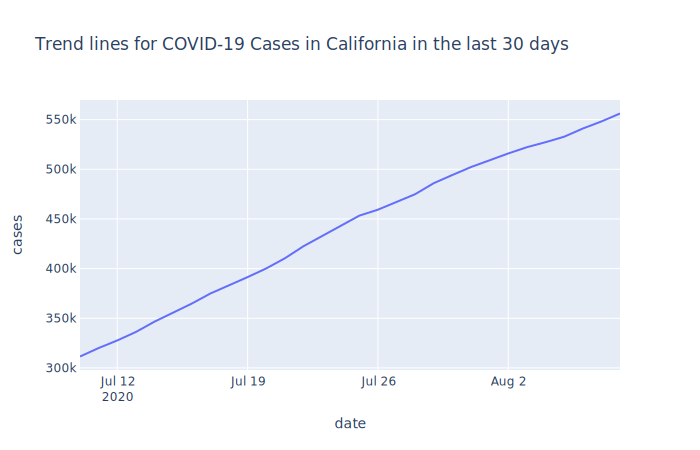

In [145]:
fig = px.line(state_one, x = "date", y = "cases", title = "Trend lines for COVID-19 Cases in " + top_five_lst[0] + " in the last 30 days")
fig.show()

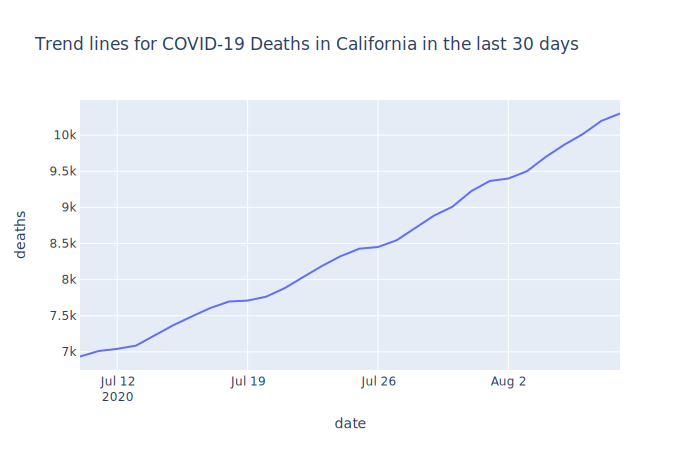

In [146]:
fig = px.line(state_one, x = "date", y = "deaths", title = "Trend lines for COVID-19 Deaths in " + top_five_lst[0] + " in the last 30 days")
fig.show()

## Trend lines for COVID-19 Cases & Deaths in the 2nd most infected state in the US

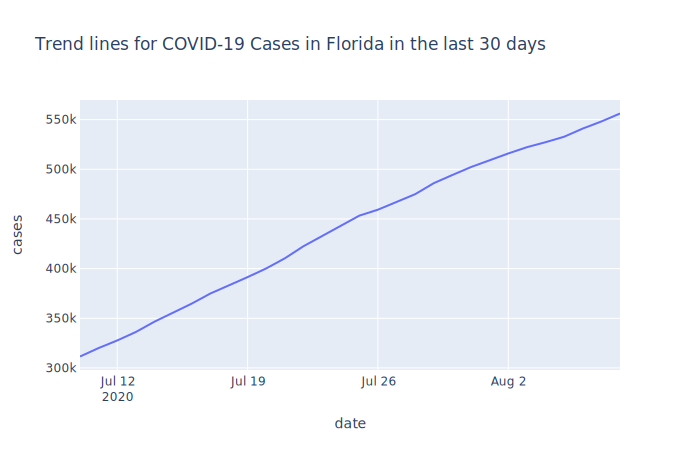

In [147]:
fig = px.line(state_one, x = "date", y = "cases", title = "Trend lines for COVID-19 Cases in " + top_five_lst[1] + " in the last 30 days")
fig.show()

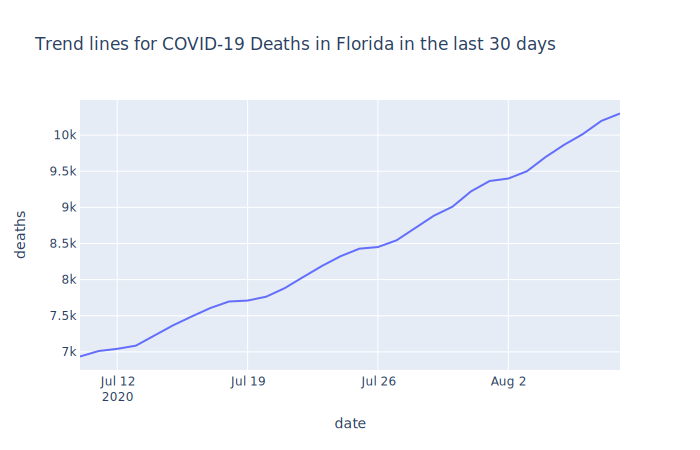

In [148]:
fig = px.line(state_one, x = "date", y = "deaths", title = "Trend lines for COVID-19 Deaths in " + top_five_lst[1] + " in the last 30 days")
fig.show()

## Trend lines for COVID-19 Cases & Deaths in the 3rd most infected state in the US

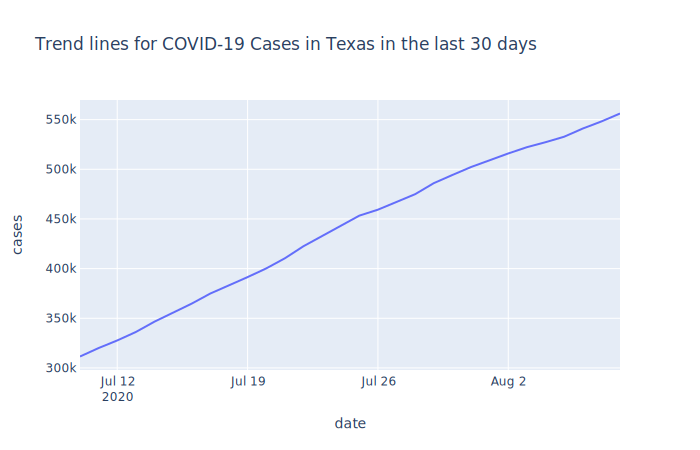

In [149]:
fig = px.line(state_one, x = "date", y = "cases", title = "Trend lines for COVID-19 Cases in " + top_five_lst[2] + " in the last 30 days")
fig.show()

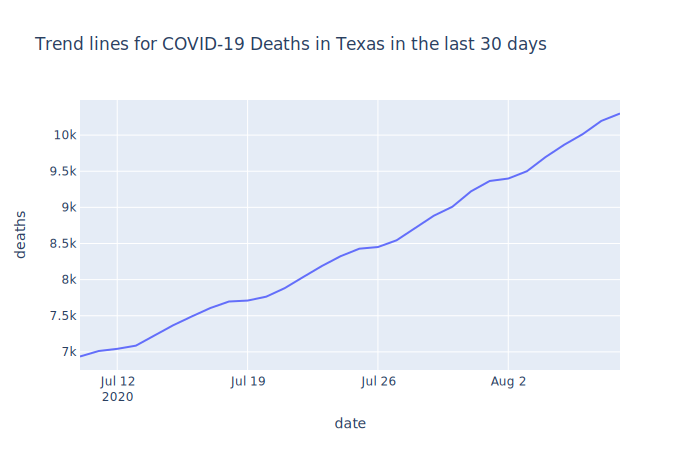

In [150]:
fig = px.line(state_one, x = "date", y = "deaths", title = "Trend lines for COVID-19 Deaths in " + top_five_lst[2] + " in the last 30 days")
fig.show()

## Trend lines for COVID-19 Cases & Deaths in the 4th most infected state in the US

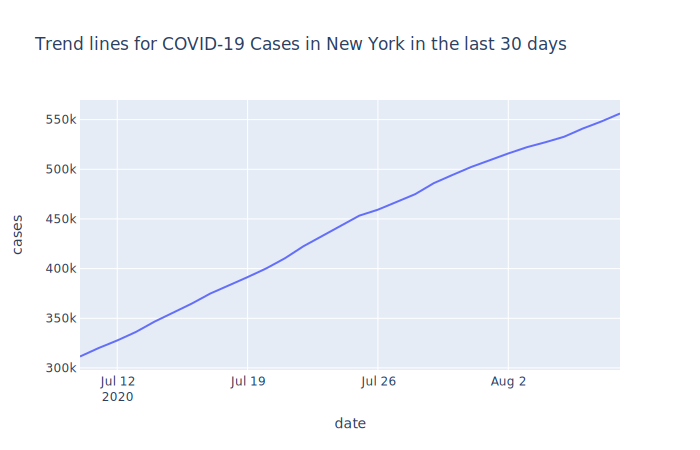

In [151]:
fig = px.line(state_one, x = "date", y = "cases", title = "Trend lines for COVID-19 Cases in " + top_five_lst[3] + " in the last 30 days")
fig.show()

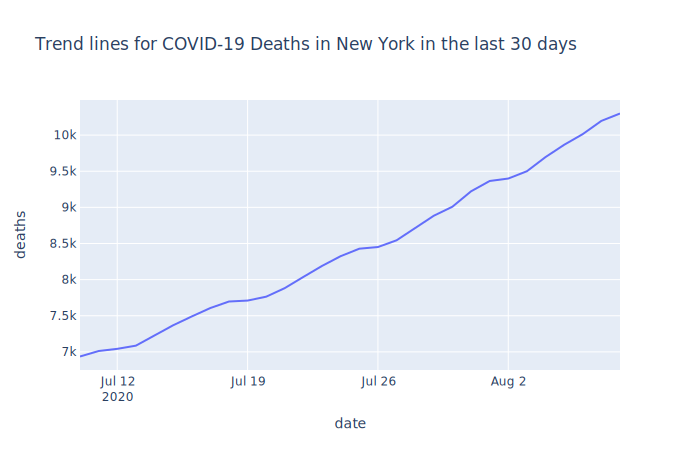

In [152]:
fig = px.line(state_one, x = "date", y = "deaths", title = "Trend lines for COVID-19 Deaths in " + top_five_lst[3] + " in the last 30 days")
fig.show()

## Trend lines for COVID-19 Cases & Deaths in the 5th most infected state in the US

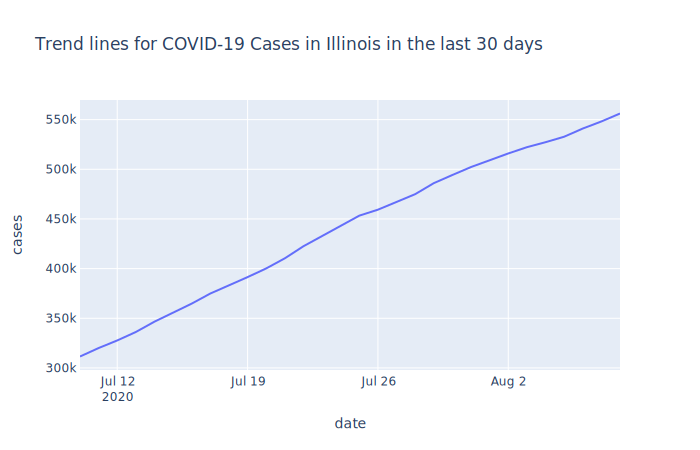

In [153]:
fig = px.line(state_one, x = "date", y = "cases", title = "Trend lines for COVID-19 Cases in " + top_five_lst[4] + " in the last 30 days")
fig.show()

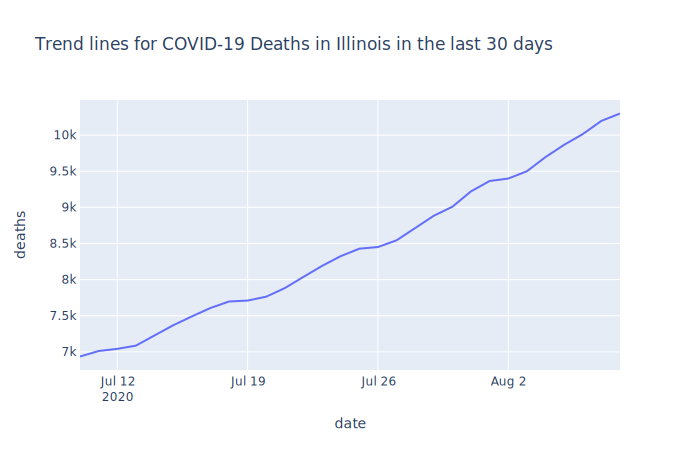

In [154]:
fig = px.line(state_one, x = "date", y = "deaths", title = "Trend lines for COVID-19 Deaths in " + top_five_lst[4] + " in the last 30 days")
fig.show()

## Concepts Used: Inner join, boolean, loc, sum(), DataFrame
## Visualizations Used: Bar Charts, Sunbursts, Heatmaps, Line Graphs